IA & Data science (3i026) -- 2018-2019
--------
*&copy; Equipe pédagogique: Manon Ansart, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*

# TD-TME08: algorithme des k-moyennes

L'objectif de ce TP est d'implémenter un nouvel algorithme d'apprentissage non-supervisé, l'algorithme des K-moyennes (cours 9).

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Leygonie Rebecca Laouer Walid

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Compléter le nom de ce notebook en rajoutant les noms des membres du binômes séparés par un tiret.

## Préparation

Décompresser l'archive, elle crée le répertoire "tp8" qui contient un fichier ipython à ouvrir (ce fichier-ci) et un sous-répertoire "data" contenant les bases d'apprentissage utilisées dans ce TP.

In [134]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  
import random as rd
import math

## Travail à réaliser
Le travail à faire se décompose en 2 phases :
- dans un premier temps, le travail porte sur la base d'apprentissage <code>base-2D.csv</code> qui contient des exemples décrits dans $R^2$. Ainsi, il est plus aisé de visualiser les résultats des fonctions à écrire ;
- dans un second temps, les fonctions écrites dans la phase précédente sont à utiliser avec la base d'apprentissage "base-Paris.csv".

**Attention**: vos fonctions doivent **dès leur création** pouvoir s'appliquer **quelle que soit la dimension** des exemples traités.


### Important :
Dans la suite de ce TP, on appelle:

- "base d'apprentissage" le dataframe contenant l'ensemble des exemples d'apprentissage chargés par la commande précédente
- "base d'exemples" : un dataframe contenant un ensemble d'exemples (remarque: la base d'apprentissage est le plus grand ensemble d'exemples possible)

**Rappel**: avec un dataframe, il est facile d'accéder à tous les éléments d'une colonne, par exemple si <code>DF</code> est un dataframe, '<code>DF['X']</code> permet de récupérer une <code>Series</code> contenant toutes les lignes de la colonne de nom 'X'.
On peut accéder à une ligne (ou un ensemble de ligne) très facilement:
- <code>DF.iloc[0]</code> permet de récupérer la ligne d'indice 0 sous la forme d'une "series"
- <code>DF.iloc[0:1]</code> permet de récupérer la ligne d'indice 0 sous la forme d'un dataframe (cettte instruction réalise un "slicing")
- <code>DF.iloc[0:5]</code> permet de récupérer les lignes d'indice de 0 à 4

etc.

### Données d'expérimentation

Commencer par charger le fichier <code>base_2D.csv</code> qui permettra d'expérimenter vos fonctions. Dans ce qui suit, on note <code>data_2D</code> le dataframe qui contient les données de ce fichiers.


In [4]:
data_2D = pd.read_csv("data/base-2D.csv")
data_2D.head()

,X,Y
0,0.0,4.0
1,1.0,3.5
2,1.0,1.0
3,2.0,1.0
4,2.0,2.0


In [5]:
print(data_2D['X']-data_2D['Y'])

0    -4.0
1    -2.5
2     0.0
3     1.0
4     0.0
5     0.0
6    -1.0
7    -2.0
8     3.5
9    -1.5
10    4.0
11    0.0
12    4.0
13    3.0
dtype: float64


In [6]:
data_2D - data_2D.min()

,X,Y
0,0.0,3.0
1,1.0,2.5
2,1.0,0.0
3,2.0,0.0
4,2.0,1.0
5,4.0,3.0
6,4.0,4.0
7,4.0,5.0
8,4.5,0.0
9,4.5,5.0


## Partie 1 : fonctions utiles (et retour vers la séance dernière)

<font size="+1" color="RED">**[Q]**</font> (Ré)écrire la fonction <code>normalisation()</code> du TD-TME07: cette fonction doit prendre en argument un <code>DataFrame DF</code> et rendre **le dataframe** obtenu en normalisant chaque colonne de <code>DF</code> par la méthode vue en cours 8.

In [7]:
def normalisation(DF):
    return (DF - DF.min())/(DF.max()-DF.min())


In [8]:
normalisation(data_2D)

,X,Y
0,0.000000,0.6
1,0.142857,0.5
2,0.142857,0.0
3,0.285714,0.0
4,0.285714,0.2
5,0.571429,0.6
6,0.571429,0.8
7,0.571429,1.0
8,0.642857,0.0
9,0.642857,1.0


---> type de DataFnorm: <class 'pandas.core.frame.DataFrame'>


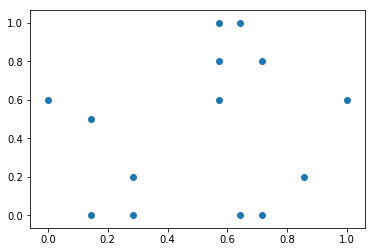

In [9]:
# Affichage des points après normalisation:

DataFnorm = normalisation(data_2D)
print("---> type de DataFnorm:",type(DataFnorm))

plt.scatter(DataFnorm['X'],DataFnorm['Y'])

<font size="+1" color="RED">**[Q]**</font> Réécrire la fonction <code>dist_vect()</code> qui calcule la distance euclidienne entre deux <code>Series</code>.

In [87]:
def dist_vect(S1,S2):
    return np.sqrt(np.sum((S1-S2)**2))

In [11]:
dist_vect(DataFnorm.iloc[0],DataFnorm.iloc[7])

0.6975174637562116

### Calcul de centroides

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>centroide()</code> qui, étant donné un DataFrame représentant plusieurs exemples rend le centroide. Cette fonction doit rendre un DataFrame.

In [12]:
data_2D.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
X,0.0,1.0,1.0,2.0,2.0,4.0,4.0,4.0,4.5,4.5,5.0,5.0,6.0,7.0
Y,4.0,3.5,1.0,1.0,2.0,4.0,5.0,6.0,1.0,6.0,1.0,5.0,2.0,4.0


In [13]:
def centroide(DF):
    return pd.DataFrame(DF.mean()).T

In [14]:
centroide(DataFnorm)

,X,Y
0,0.510204,0.45


## Partie 2: implémentation des k-moyennes

### Inertie d'un cluster
<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>inertie_cluster</code> qui, étant donné un DataFrame contenant un ensemble d'exemples, rend la valeur de l'inertie de cet ensemble telle qu'elle a été définie dans le cours.

In [99]:
def dist_vect1(S1,S2):
    S1 = S1.as_matrix()
    S2 = S2.as_matrix().reshape(2)
    return np.sqrt(np.sum((S1-S2)**2,axis=1))

In [96]:
def inertie_cluster(DF):
    return np.sum(dist_vect1(DF,centroide(DF))**2)

In [17]:
print("inertie :",inertie_cluster(DataFnorm))

inertie : 2.975991253644316


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Dans ce qui suit, on appelle "ensemble de centroides" un dataframe contenant $K$ vecteurs de dimensions $p$.

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>initialisation()</code> qui étant donné un entier $K>1$ et une base d'apprentissage (sous la forme d'un DataFrame) de $n$ exemples rend un dataframe contenant $K$ exemples tirés aléatoirement dans la base.
On fait l'hypothèse que $K\leq n$.

*Remarque*: étudier les fonctions de la librairie random de Python...


In [18]:
DataFnorm.columns

Index(['X', 'Y'], dtype='object')

In [19]:
DataFnorm.loc[1]

X    0.142857
Y    0.500000
Name: 1, dtype: float64

In [20]:
def initialisation(K,DF):
    K_dataFrame=pd.DataFrame(columns=list(DF.columns))
    for n in range(0,K):
        i=rd.randint(0,len(DF)-1)
        K_dataFrame.loc[i]=DF.iloc[i]
    return K_dataFrame

In [25]:
# Par exemple (mais vous ne devriez pas pouvoir retrouver exactement les mêmes !)
Centroides_test = initialisation(3,DataFnorm)
Centroides_test

,X,Y
8,0.642857,0.0
0,0.000000,0.6
2,0.142857,0.0


En utilisant l'option <code>"color='blue'"</code> ou <code>"color='red'"</code> de la fonction <code>scatter()<code>, on peut réaliser l'affichage de la base d'apprentissage (en bleu) et des centroides initiaux (en rouge).

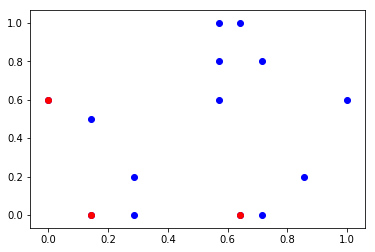

In [26]:
plt.scatter(DataFnorm['X'],DataFnorm['Y'],color='blue')
plt.scatter(Centroides_test['X'],Centroides_test['Y'],color='red')

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>plus_proche()</code> qui, étant donné un exemple et un dataframe contenant un ensemble de centroides, rend l'indice (dans le DataFrame) du centroide dont l'exemple est le plus proche.
En cas d'égalité de distance, le centroide de plus petit indice est choisi.

In [34]:
print(Centroides_test.iloc[1])

X    0.0
Y    0.6
Name: 0, dtype: float64


In [121]:
def plus_proche(exemple,DF):
    Min = 1000
    ind=-1000
    for i in range(0,len(DF)):
        minTempo=dist_vect(DF.iloc[i],exemple)
        if (Min>minTempo):
            Min=minTempo
            ind=i
    return ind
    

In [122]:
for i in range(0,len(DataFnorm)):
    pproche = plus_proche(DataFnorm.iloc[i],Centroides_test)
    print("Exemple ",i,": (",DataFnorm.iloc[i]['X'],", ",DataFnorm.iloc[i]['Y'], ")","est plus proche du centroide",pproche, ": (",Centroides_test.iloc[pproche]['X'],", ", Centroides_test.iloc[pproche]['Y'],")")

Exemple  0 : ( 0.0 ,  0.6 ) est plus proche du centroide 1 : ( 0.0 ,  0.6 )
Exemple  1 : ( 0.14285714285714285 ,  0.5 ) est plus proche du centroide 1 : ( 0.0 ,  0.6 )
Exemple  2 : ( 0.14285714285714285 ,  0.0 ) est plus proche du centroide 2 : ( 0.14285714285714285 ,  0.0 )
Exemple  3 : ( 0.2857142857142857 ,  0.0 ) est plus proche du centroide 2 : ( 0.14285714285714285 ,  0.0 )
Exemple  4 : ( 0.2857142857142857 ,  0.2 ) est plus proche du centroide 2 : ( 0.14285714285714285 ,  0.0 )
Exemple  5 : ( 0.5714285714285714 ,  0.6 ) est plus proche du centroide 1 : ( 0.0 ,  0.6 )
Exemple  6 : ( 0.5714285714285714 ,  0.8 ) est plus proche du centroide 1 : ( 0.0 ,  0.6 )
Exemple  7 : ( 0.5714285714285714 ,  1.0 ) est plus proche du centroide 1 : ( 0.0 ,  0.6 )
Exemple  8 : ( 0.6428571428571429 ,  0.0 ) est plus proche du centroide 0 : ( 0.6428571428571429 ,  0.0 )
Exemple  9 : ( 0.6428571428571429 ,  1.0 ) est plus proche du centroide 1 : ( 0.0 ,  0.6 )
Exemple  10 : ( 0.7142857142857143 ,  0.

### Matrice d'affectation

Etant donné une base d'apprentissage, on peut représenter une partition de cette base en K clusters à l'aide d'une matrice U contenant n lignes (une par exemple) et K colonnes (une par cluster) telle que 
- U[i,j] = 1 si l'exemple i appartient au cluster j
- U[i,j] = 0 si l'exemple i n'appartient pas au cluster j
- un exemple appartient à un et un seul cluster
- un cluster contient au moins un exemple

On appelle **matrice d'affectation** une telle matrice U.


<font size="+1" color="RED">**[Q]**</font> Donner une expression mathématique (pas du Python) des 2 dernières contraintes que vérifie une matrice d'affectation.

### Implémentation en Python
Nous utilisons un dictionnaire pour représenter d'une matrice d'affectation: 
- les clés de ce dictionnaire correspondent aux $K$ indices des clusters
- les valeurs correspondent à des listes d'indices d'exemples (leur indice dans la base d'apprentissage)

Dans tout ce qui suit, une "matrice d'affectation" sera un tel dictionnaire.


<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>affecte_cluster()</code> qui, étant donné une base d'apprentissage et un ensemble de centroïdes, rend la matrice d'affectation des exemples de la base aux clusters représentés par chaque centroïde.

In [123]:
def affecte_cluster(DF,centroide):
    matrice=dict()
    for i in range(len(centroide)):
        matrice[i]=[]
    for j in range(len(DF)):
        c=plus_proche(DF.loc[j],centroide)
        matrice[c].append(j)
    return matrice

In [124]:
DictAffect = affecte_cluster(DataFnorm, Centroides_test)
DictAffect

{0: [8, 10, 12, 13], 1: [0, 1, 5, 6, 7, 9, 11], 2: [2, 3, 4]}

### Ensemble des centroides
Grâce à la matrice d'affectation, on peut maintenant trouver les nouveaux centroides. Ceux-ci sont déterminés en prenant les moyennes des ensembles des exemples qui sont affectés au même cluster.

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>nouveaux_centroides()</code> qui, étant donné une base d'apprentissage et une matrice d'affectation, rend l'ensemble des nouveaux centroides obtenus.

In [127]:
print(DictAffect.items())

dict_items([(0, [8, 10, 12, 13]), (1, [0, 1, 5, 6, 7, 9, 11]), (2, [2, 3, 4])])


In [130]:
def nouveaux_centroides(DF,matrice):
    df=pd.DataFrame(columns=list(DF.columns))
    for cluster, exemple in matrice.items():
        moyenne=0
        for i in range (len(exemple)):
            moyenne=moyenne+DF.iloc[exemples[i]]
        df.loc[cluster]=1.0*moyenne/len(exemple)
    return df

In [131]:
nouveaux_centroides(DataFnorm, DictAffect)

,X,Y
0,0.803571,0.200000
1,0.459184,0.757143
2,0.238095,0.066667


### Inertie globale d'une partition

<font size="+1" color="RED">**[Q]**</font> En utilisant la fonction <code>inertie_cluster()</code>, écrire la fonction <code>inertie_globale()</code> qui, étant donné une base d'apprentissage et une matrice d'affectation, rend la valeur de l'inertie globale du partitionnement correspondant.


In [132]:
def inertie_globale(DF,matrice):
    nouveaux=nouveaux_centroides(DF,matrice)
    inertie=0
    
    for cluster, exemple in matrice.items():
        df=pd.DataFrame(columns=list(DF.columns))
        df=DF.iloc[exemple]
        inertie+=inertie_cluster(df)
    return inertie
        

In [133]:
inertie_globale(DataFnorm,DictAffect)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


1.0401919339164236

### Algorithme des K-moyennes

<font size="+1" color="RED">**[Q]**</font> En utilisant les fonctions précédentes, implémenter l'algorithme des K-moyennes.
Pour cela, écrire une fonction <code>kmoyennes()</code> qui prend en argument un entier $K>1$, une base d'apprentissage, ainsi que deux nombres: un réel *epsilon*$>0$ et un entier *iter_max*$>1$, et qui rend un ensemble de centroides et une matrice d'affectation.

Le réel *epsilon* servira de critère de convergence, et l'entier *iter_max* sera utilisé pour fixer un nombre d'itérations maximale servant à arrêter le calcul.

In [140]:
def kmoyennes(K,DF,epsilon,iter_max):
    centroid=initialisation(K,DF)
    inertie=inertie_cluster(DF)
    
    for i in range(0,iter_max):
        matrice=affecte_cluster(DF,centroid)
        Nouvelle_inertie=inertie_globale(DF,matrice)
        inertie=Nouvelle_inertie
        centroid=nouveaux_centroides(DF,matrice)
        
    return centroid, matrice

In [141]:
les_centres, l_affectation = kmoyennes(2, DataFnorm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Affichage des centres:            X         Y
0  0.488095  0.066667
1  0.526786  0.737500
Affichage des affectations:  {0: [2, 3, 4, 8, 10, 12], 1: [0, 1, 5, 6, 7, 9, 11, 13]}


In [142]:
les_centres, l_affectation = kmoyennes(3, DataFnorm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Affichage des centres:            X         Y
0  0.488095  0.066667
1  0.071429  0.550000
2  0.678571  0.800000
Affichage des affectations:  {0: [2, 3, 4, 8, 10, 12], 1: [0, 1], 2: [5, 6, 7, 9, 11, 13]}


On peut réaliser un affichage couleur des centroïdes trouvés:

In [ ]:
plt.scatter(DataFnorm['X'],DataFnorm['Y'],color='b')
plt.scatter(les_centres['X'],les_centres['Y'],color='r',marker='x')

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>affiche_resultat()</code> qui permet d'afficher le résultat de l'algorithme en utilisant des couleurs différentes pour les clusters trouvés (pour faire simple, on peut ne considèrer que le cas où K vaut 3).

*Remarque*: La librairie matplotlib permet de manipuler aisément des couleurs:
http://matplotlib.org/api/cm_api.html

In [ ]:
affiche_resultat(DataFnorm,les_centres,l_affectation)

### Expérimentations

<font size="+1" color="RED">**[Q]**</font> Expérimenter l'algorithme des k-moyennes sur les données. Etudier l'impact du choix de $K$ sur l'inertie globale finale. Faire de même en relançant plusieurs fois l'algorithme avec la même valeur de $K$, en modifiant la valeur de epsilon ou de max_iter, etc.

## Application à des données réelles

- Appliquer l'algorithme aux données concernant les déchets de la ville de Paris (qui sont fournies dans le répertoire data)
- Trouver des bases d'apprentissage intéressantes sur http://opendata.paris.fr/


Dans les 2 cas, étudier la base et les clusters qui peuvent être mis en évidence. En particulier, regarder la variation de l'inertie globale des clusters obtenus en fonction de la valeur de $K$ choisie.


**Attention**: il faudra certainement préparer cette base afin de pouvoir appliquer l'algorithme de clustering: en particulier, certaines colonnes (Granularité, Total...) ne sont pas à utilisables dans le calcul des distances, il faudra donc les éliminer. Il faut aussi prévoir de conserver le nom de l'arrondissement afin de pouvoir à la fin analyser le résultat du clustering.

## Questions de cours (à faire chez vous, sur papier)

Pour vous entraîner sans machine...

<font size="+1" color="RED">**[Q]**</font> On considère un ensemble fini $U$ d'éléments. 
- donner la fonction caractéristique de $U$
- donner la fonction caractéristique de l'ensemble vide
- soit $E$ et $F$ deux sous-ensembles de $U$ définis par leurs fonctions caractéristiques $\chi_E$ et $\chi_F$. En déduire les fonctions caractéristiques de $E\cup F$, de $E\cap F$ et de $E^{c}$. *(indice: penser au min et au max)*

<font size="+1" color="RED">**[Q]**</font> Rappeler la définition d'une partition $P$ d'un ensemble $X$ en $K$ sous-ensembles. 

<font size="+1" color="RED">**[Q]**</font> Appliquer, à la main, l'algorithme des K-moyennes sur les données fournies sur le transparent 10 du cours 8 en utilisant d'abord $K=2$, puis $K=3$. Dans chacun des cas, réaliser au maximum 10 itérations de l'algorithme ($t_{max}=10$).
Comparer les résultats obtenus.


---